In [2]:
import sys
import os
from itertools import chain
from collections import defaultdict
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('precision', 3)
import gseapy as gp
import goatools
import numpy as np
from adjustText import adjust_text
import seaborn as sns
sns.set_style('whitegrid')

obodag = goatools.obo_parser.GODag('go-basic.obo')
sys.path.insert(0, "/home/gstupp/projects/metaproteomics")
from metaproteomics import utils
#from metaproteomics.analysis import build_loci

BASE = '../out/'

load obo file go-basic.obo
go-basic.obo: fmt(1.2) rel(2017-03-16) 48,478 GO Terms


In [34]:
def get_all_children(go_id):
    children = set([x.id for x in obodag.get(go_id).children])
    children.add(go_id)
    new_children = children
    while True:
        new_children = set(chain(*[[x.id for x in obodag.get(y).children] for y in new_children]))
        if not new_children:
            break
        children.update(new_children)
    return children
len(get_all_children('GO:0006928'))

394

In [35]:
"GO:0040011" in [obodag[x].id for x in get_all_children('GO:0006928')]

False

In [92]:
topgo = {'GO:0006928', 'GO:0051179', 'GO:0006807', 'GO:0005975', 'GO:0043170'}
topgo_children = {k:get_all_children(k) for k in topgo}
group_names = {x:"{} ({})".format(obodag.get(x).name, obodag.get(x).id) for x in topgo}
group_names[None] = None
#group_names["multiple"] = "Multiple"

In [93]:
# add locomotion(GO:0040011) to movement of cell or subcellular component (GO:0006928)'
topgo_children['GO:0006928'].update(get_all_children('GO:0040011'))
group_names['GO:0006928'] = "locomotion(GO:0040011) / movement of cell or subcellular component (GO:0006928)"

In [94]:
# add Nitrogen compound metabolic process (GO:0006807) to ribose phosphate metabolic process (GO:GO:0019693)'
topgo_children['GO:0006807'].update(get_all_children('GO:0019693'))
group_names['GO:0006807'] = "nitrogen compound metabolic process (GO:0006807) / ribose phosphate metabolic process (GO:0019693)"

In [95]:
# add Regulation of metabolic processes (GO:0019222) to macromolecule metabolic process (GO:0043170)''
topgo_children['GO:0043170'].update(get_all_children('GO:0019222'))
group_names['GO:0043170'] = "macromolecule metabolic process (GO:0043170) / regulation of metabolic process (GO:0019222)"

In [96]:
# remove cell motility from localization
print(len(topgo_children['GO:0051179']))
remove = set(chain(*[get_all_children(x) for x in ['GO:0048870']]))
topgo_children['GO:0051179'] = [x for x in topgo_children['GO:0051179'] if x not in remove]
print(len(topgo_children['GO:0051179']))

# remove translation (GO:0006412) from ncmp/rpmp (0006807)
print(len(topgo_children['GO:0006807']))
remove = set(chain(*[get_all_children(x) for x in ['GO:0006412']]))
topgo_children['GO:0006807'] = [x for x in topgo_children['GO:0006807'] if x not in remove]
print(len(topgo_children['GO:0006807']))

# remove stuff from mp (0043170)
print(len(topgo_children['GO:0043170']))
mp_remove = ['GO:0005976', 'GO:0006073', 'GO:0033692', 'GO:0009250', 'GO:0044042', 'GO:0044264', 'GO:0005978', 'GO:0000271', 'GO:0005977']
remove = set(chain(*[get_all_children(x) for x in mp_remove]))
topgo_children['GO:0043170'] = [x for x in topgo_children['GO:0043170'] if x not in remove]
print(len(topgo_children['GO:0043170']))

2188
2188
2820
2814
5793
5572


In [97]:
group_names

{'GO:0006928': 'locomotion(GO:0040011) / movement of cell or subcellular component (GO:0006928)',
 None: None,
 'GO:0005975': 'carbohydrate metabolic process (GO:0005975)',
 'GO:0043170': 'macromolecule metabolic process (GO:0043170) / regulation of metabolic process (GO:0019222)',
 'GO:0051179': 'localization (GO:0051179)',
 'GO:0006807': 'nitrogen compound metabolic process (GO:0006807) / ribose phosphate metabolic process (GO:0019693)'}

In [98]:
group_colors = {k:c for k,c in zip(topgo, ['r', 'g', 'b', 
                                           'darkorange', 'magenta'])}
group_colors[None] = 'k'
#group_colors['multiple'] = 'deeppink'
color_group = {v:k for k,v in group_colors.items()}
group_colors

{'GO:0006928': 'r',
 None: 'k',
 'GO:0005975': 'g',
 'GO:0043170': 'b',
 'GO:0051179': 'darkorange',
 'GO:0006807': 'magenta'}

In [99]:
def get_go_group(go):
    if not isinstance(go, str):
        return None
    membership = {k:any([x in v for x in go.split("|")]) for k,v in topgo_children.items()}
    if list(membership.values()).count(True)>1:
        group = None
    elif list(membership.values()).count(True)==1:
        group = [k for k,v in membership.items() if v][0]
    else:
        group = None
    return group

In [122]:
def plot(df_sig, df_insig, plot_name):
    fig = plt.figure(figsize=(15, 9))
    fig.set_tight_layout(False)
    ax = fig.add_subplot(111)

    # Plot the INsig points
    X = df_insig['log2FoldChange'].values
    Y = df_insig['-logp'].values
    ax.scatter(X, Y, color='silver', s=20)

    # Plot the sig points
    for color in set(df_sig['color']):
        X = df_sig[df_sig.color == color].log2FoldChange
        Y = df_sig[df_sig.color == color]['-logp']
        ax.scatter(X, Y, color=color, s=40, label=group_names[color_group[color]])

    ax.xaxis.set_label_text("Log(2) Fold Change")
    ax.yaxis.set_label_text("-logp")
    ax.set_xlim(-10,10)
    ax.set_ylim(0,40)
    fig.savefig(plot_name + "_microbe_volcano.pdf")
    #ax.legend(loc=2, fontsize='large')

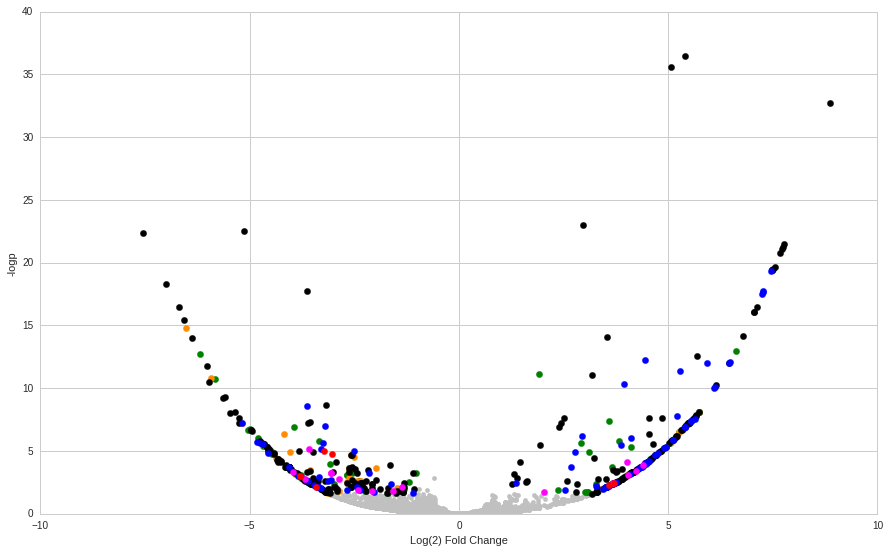

In [123]:
df = pd.read_csv(os.path.join(BASE,"RT_control_results_named_annot.csv"), index_col=0)
df = df[~df.human_mouse]
df['-logp'] = -1*np.log(df.padj)
df['group'] = df.go.apply(get_go_group)
df['color'] = df.group.apply(group_colors.get)
df_sig = df[(df.padj<=0.2) & (abs(df.log2FoldChange) >= 1)]
df_insig = df[~((df.padj<=0.2) & (abs(df.log2FoldChange) >= 1))]
plot(df_sig, df_insig, 'rt_control')

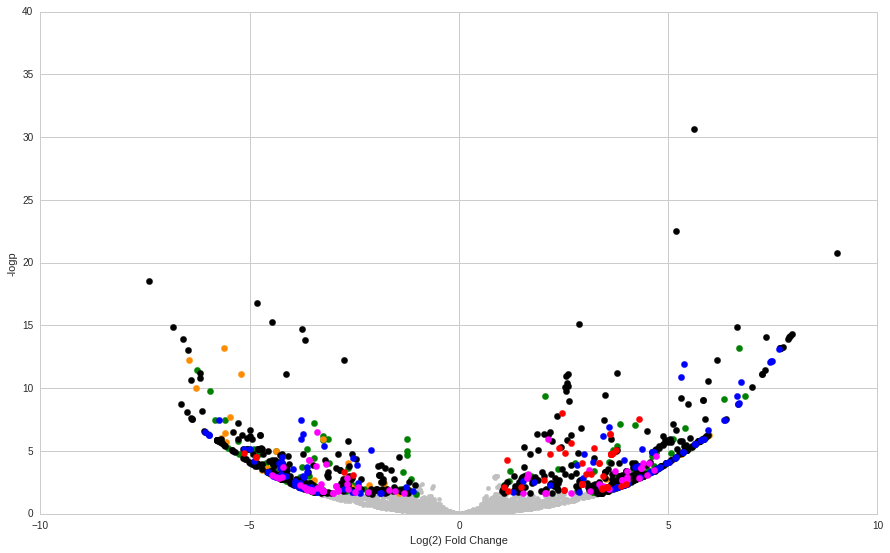

In [124]:
df = pd.read_csv(os.path.join(BASE,"RT_WT_results_named_annot.csv"), index_col=0)
df = df[~df.human_mouse]
df['-logp'] = -1*np.log(df.padj)
df['group'] = df.go.apply(get_go_group)
df['color'] = df.group.apply(group_colors.get)
df_sig = df[(df.padj<=0.2) & (abs(df.log2FoldChange) >= 1)]
df_insig = df[~((df.padj<=0.2) & (abs(df.log2FoldChange) >= 1))]
plot(df_sig, df_insig, 'rt_wt')

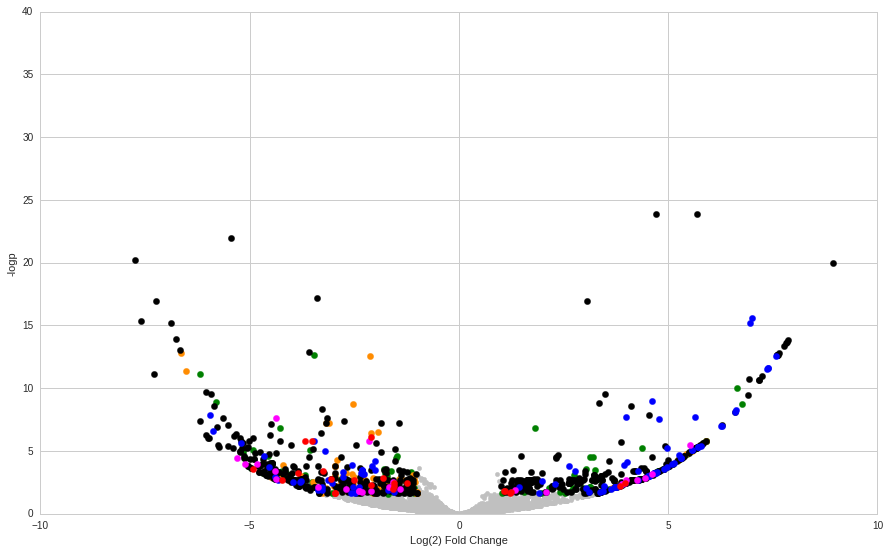

In [125]:
df = pd.read_csv(os.path.join(BASE,"RT_Rag_results_named_annot.csv"), index_col=0)
df = df[~df.human_mouse]
df['-logp'] = -1*np.log(df.padj)
df['group'] = df.go.apply(get_go_group)
df['color'] = df.group.apply(group_colors.get)
df_sig = df[(df.padj<=0.2) & (abs(df.log2FoldChange) >= 1)]
df_insig = df[~((df.padj<=0.2) & (abs(df.log2FoldChange) >= 1))]
plot(df_sig, df_insig, 'rt_rag')

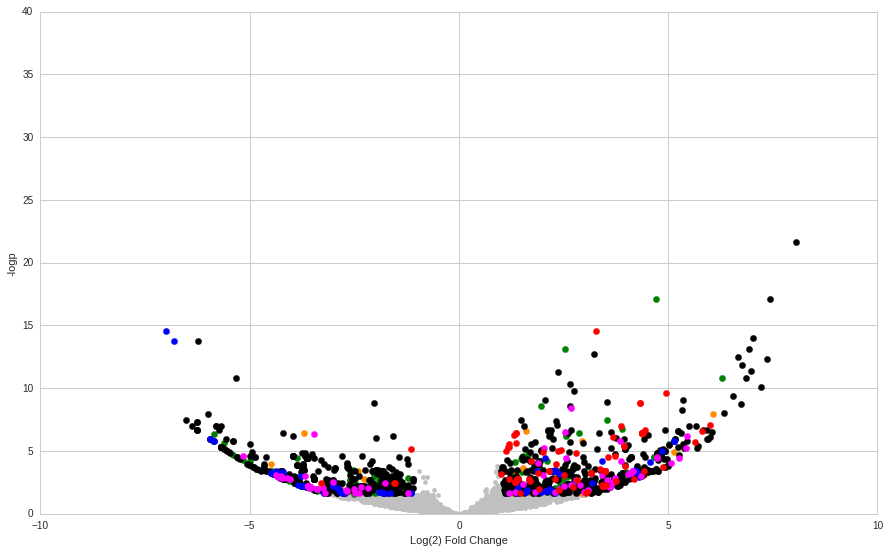

In [126]:
df = pd.read_csv(os.path.join(BASE,"Rag_WT_results_named_annot.csv"), index_col=0)
df = df[~df.human_mouse]
df['-logp'] = -1*np.log(df.padj)
df['group'] = df.go.apply(get_go_group)
df['color'] = df.group.apply(group_colors.get)
df_sig = df[(df.padj<=0.2) & (abs(df.log2FoldChange) >= 1)]
df_insig = df[~((df.padj<=0.2) & (abs(df.log2FoldChange) >= 1))]
plot(df_sig, df_insig, 'rag_wt')